# Analysis of Crowdfunding Projects

### Data Description

Kickstarter.com is a crowd funding website where creators post descriptions of projects they want to create, and individuals contribute some amount of personal money to finance the project. In return for funding, contributors typically get a wide range of “Backer Rewards”. The rewards differ depending on the type of project. For example, a book/video project will typically issue a digital copy of the final product to backers that donate above a given amount. The scope of projects can vary widely, from the initial factory runs of complex hardware products. One creator simply requested ten dollars so he could make some potato salad and instead raised $55,000 and threw a crazy party

### Data Source

Webrobots.io runs a monthly scrape of all Kickstarter projects available on the Kickstarter website. The resulting data are available as both csv and json files, and each package covers a number of projects on the website from the start date (April 21st 2009) until the scrape date. From April 2015, Kickstarter began limiting the number of search results for each category. As a result, the numbers of historical results displayed are limited. Webrobots started running scrapes in multiple sub-categories to capture more instances, and as a result, there are multiple entries for several projects.

### Dates of Study

The scrape data that I'm working with was taken from Kickstarter.com in March of 2019. The scrape data includes both historical and current projects, so there's a wide variety of dates captured here.

# Data issues

### Inconsistent Dates

Kickstarter.com limits the number of search results shown for each category of project (ex. 'Film & Video', or 'Publishing'). Because of this limit and because the number of projects in each category varies based on their relative popularity, the active dates for projects across different categories are not all the same. As we'll see later, the popularity of the Kickstarter.com website fluctuates over time, so different launch dates can affect a project's chances of success

### Missing, incorrect or duplicate data

The overall quality of the dataset is very good, with very few pieces of missing data.

# Scope and Goals

### Audience and Business Need

This project is aimed at creators that are interested launching projects on Kickstarter's platform. Kickstarter campaigns are "all or nothing", meaning if a campaign doesn't reach the funding goal, all of the funds are returned to backers. For this reason, it's important for campaigns to carefully consider how their project is presented

### Previous Work 

There's been a lot of work published using Kickstarter datasets in the past. Most of the past work has focused on trying to predict whether a project will achieve their funding goal based on characteristics such as funding goal, project  category, and number of backers. While that's interesting from a technical/model optimization view, actionable information for creators is limited so far. 

Citations for previous work is given in Appendix B at the end of this notebook

### Project Goal

In light of the previous work done and the popularity of the dataset, this project attempts to approach this dataset from an original angle. The main question I'm trying to answer here is:

* *Can we create a way for new creators to make their campaigns "look" like successful projects* 

This project aims to achieve that by running a segmentation analysis on attributes of successful and unsuccesful projects and try to uncover their differences



# Data Cleaning and Manipulation

### JSON Formatting

Many of columns in the original dataset were returned as JSON objects during the webrobots scrape. When exporting to a .csv file, and then importing into Pandas, the JSON formatting was lost. The cleaning script made for this project re-applied the JSON formatting, and then pulled the relevant information back out

### Interpreted Data
Some columns were made with interpreted data. Time deltas were calculated between:
* Campaign launch date and campaign creation date
* Campaign launch date and campaign deadline
* Campaign launch date and date funding goal was reached

Natural Language Processing was run on project titles and descriptions to better define project differences. The data from the NLP analysis was used to score project descriptions on their active phrasing and whatever other criteria I make up 

### Pruning and other cleaning
The remaining cleaning work has been selecting the data relevant to the project. The original dataset contained contained image url's, and duplicates of data available in other columns. These items were removed from the dataset used for analysis

### Date formats 

All of the columns that are time/date related are in epoch time, and I've left it that way to make things easier to do math

### External Data

Data pulled from IndieGoGo has been merged in with the Kickstarter dataset for comparison

In [1]:
#Import libraries needed for analysis
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pdb
import time
import re
import os
import math as mt

url = 'https://tufts.box.com/shared/static/939cuad4z6ieo8njf3ya58a603q4enyh.csv'
if not os.path.exists('2019KickDataCleaned.csv'):
    df = pd.read_csv(url)
else:
    df = pd.read_csv('2019KickDataCleaned.csv', index_col = 0)

df.drop(columns = ['subcats'], inplace = True)
df = df.drop_duplicates(subset = ['id'])
len(df)

181302

### Project states

There are four different states listed for each project in the dataset:

| State | Description|
|:---:|:---:|
|Live | Project is currently actively fundraising|
|Cancelled | Project was cancelled by the creators before the deadline | 
|Suspended | The project was suspended by Kickstarter for not meeting some criteria|
|Succesful| The project has met or exceeded the funding goal |
|Failed| The project failed to meet their funding goal| 

Since this project aims to analyze factors that make projects successful, I've filtered the dataset to include only projects that are either successful or failed

# Merge in External Data

### Alexa Site Traffic Ranking data

I snagged the Alexa global traffic ranking for Kickstarter.com for the last three years. Let's take a look and see if there's any correlation between the site's traffic ranking and the success rate of projects. I only had access to the last three years worth of ranking data, so some projects will be missing information

I'm using the launch date as a foreign key to match with Kickstarter's Alexa ranking, so I have to convert the timestamp to M/D/YYYY format

Once the timestamps are converted, merge the Alexa ranking data in with the Kickstarter data

In [2]:
url = 'https://tufts.box.com/shared/static/1xr291wybxfardn6cteqdmq08khic84t.csv' #Read the Alexa data
alexa = pd.read_csv(url, skiprows = 6) 

#Conver the launch date timestamp (in epoch time) to M/D/YYYY format
df['launch_date'] = df.apply(lambda x: time.strftime('%-m/%-d/%Y', time.localtime(x['launched_at'])), axis = 1)

#Merge the two dataframes together on the launch date column with a left join
df = df.merge(alexa, how = 'left', left_on = 'launch_date', right_on = 'Date')

### Convert Foreign Currencies to USD terms

There's a number of projects that originated outside of the US. For these projects, the funding goals are in a different currency. In order to clean up the dataframe for analysis, convert these into USD terms.

Kickstarter.com was kind enough to include the prevailing currency exchange rate at the time of the project, so I'll use that for the conversion

In [3]:
# Multiply the goal by the fx rate
df['goal'] = df.apply(lambda x: (x['goal'] * x['fx_rate']), axis = 1) 

In [4]:
# Check that the merge was successful and did what I wanted
df.head()

,Unnamed: 0,backers_count,blurb,country,created_at,creator,currency,deadline,fx_rate,goal,...,city,creLauDelta,lauDeadDelta,staLauDelta,source,funds_raised_percent,launch_date,Date,Metric,kickstarter.com
0,0,9,A comedy web series about the inherently funny...,US,1489891481,915430313,USD,1494132705,1.000000,5000.0000,...,"Austin, TX",19,30,30,Kickstarter,10.160000,4/7/2017,4/7/2017,Global Rank,548.0
1,1,36,"Cabo y un Capitán, dos soldados villistas, tra...",MX,1508479978,1011928721,MXN,1512917074,0.052034,3382.2282,...,"Mexico City, Mexico",16,35,35,Kickstarter,5.226900,11/5/2017,11/5/2017,Global Rank,528.0
2,2,61,We're building the new home of Māori Theatre a...,NZ,1426499822,1902194044,NZD,1429596000,0.685030,6850.2957,...,"Auckland, NZ",7,28,28,Kickstarter,78.343402,3/23/2015,NaN,NaN,NaN
3,3,1730,Comic-book stories celebrate women who crack c...,US,1482813229,121124061,USD,1489666144,1.000000,40000.0000,...,"Scottsdale, AZ",49,29,29,Kickstarter,243.617500,2/14/2017,2/14/2017,Global Rank,589.0
4,4,183,"A Victorian “gaslamp” lesbian romance, set in ...",US,1506228739,484654302,USD,1510473540,1.000000,2000.0000,...,"San Francisco, CA",16,32,32,Kickstarter,195.550000,10/10/2017,10/10/2017,Global Rank,503.0


### IndieGoGo Data

Webrobots.io also runs a monthly scrape of the indiegogo website. Since there's already been a large amount of work done on Kickstarter data in the past, I want to try and make some unique analyses using a new dataset.

I grabbed the most recent version of the indiegogo dataset, and now I'm going to merge it with my Kickstarter dataset

In [5]:
#Start by taking a look at the indiegogo dataset
url = 'https://tufts.box.com/shared/static/on2cmdxc4vqpm2dutaaf7l8764ktq0u5.csv'
indie = pd.read_csv('https://tufts.box.com/shared/static/on2cmdxc4vqpm2dutaaf7l8764ktq0u5.csv')
#Drop columns that are unrelatd to the original kickstarter dataset
indie.drop(labels = ['bullet_point', 'category_url', 'clickthrough_url', 'image_url', 'is_pre_launch', 'offered_by', 
                     'price_offered', 'product_id', 'product_stage', 'project_type', 'price_retail', 
                     'perk_goal_percentage', 'tags'], axis = 1, inplace = True)

In [6]:
indie.head()

,category,close_date,currency,funds_raised_amount,funds_raised_percent,is_indemand,open_date,perks_claimed,project_id,source_url,tagline,title
0,Home,2018-07-16T23:59:59-07:00,GBP,10694.0,1.065059,True,2018-07-15T23:59:59-07:00,58.0,2397370,https://www.indiegogo.com/explore/all?project_...,Make a brew for two with one press using the A...,2POUR An Accessory For Aeropress Coffee Maker
1,Web Series & TV Shows,2017-09-12T23:59:59-07:00,AUD,30.0,0.003000,False,2017-07-14T06:19:44-07:00,0.0,2152925,https://www.indiegogo.com/explore/all?project_...,This street is the stage where the theatre mee...,Hustle Street - A musical
2,Photography,2013-02-13T23:59:59-08:00,USD,7060.0,0.415294,False,2012-12-10T09:05:14-08:00,65.0,291347,https://www.indiegogo.com/explore/all?project_...,Creating a photo-narrative book that captures ...,The Thru-Project
3,Home,2017-01-07T23:59:59-08:00,EUR,20.0,0.000020,False,2016-11-24T01:51:38-08:00,2.0,1951140,https://www.indiegogo.com/explore/all?project_...,World 1st Charity Contest of religious communi...,Way2goodness
4,Health & Fitness,2018-07-11T23:59:59-07:00,USD,250036.0,6.750033,True,2018-07-10T23:59:59-07:00,532.0,2393782,https://www.indiegogo.com/explore/all?project_...,Wake up gently every morning by stimulating th...,Sensorwake Trio: The scent-based alarm clock


# Making the Indiegogo data look like the Kickstarter data

Since the two websites are unique, there's a lot of differences in how the datasets are structured

The following few steps are manipulating the indiegogo data to look like the Kickstarter data

### Date Conversion

First up, change the dates that are in a YY/MM/DD format and convert that into epoch time (the standard for the Kickstarter dataset)

In [7]:
import datetime # Library for working with datetime information
indie.dropna(inplace = True) # Drop rows that are missing important information

# Define a function to strip out the extra information on the indiegogo timestamps, and then convert to epoch time
def epoch(target): 
    '''
    This function takes a date from the indiegogo dataset (read originally as a string), converts to a datetime object
    and then converts that date to epoch time
    '''
    target = target.split('T')
    target = datetime.datetime.strptime(target[0], '%Y-%m-%d')
    target = target.strftime('%s')
    return(target)

#Run the epoch function on the project close date and project open date columns
indie.close_date = indie.close_date.apply(epoch) 
indie.open_date = indie.open_date.apply(epoch)

### Renaming Categories

The category labels for indiegogo don't quite match up to Kickstarter categories. I've made a dictionary to convert the indiegogo categories to match Kickstarter categories

Some of the categories in the indiegogo dataset didn't have an obvious counterpart in the kickstarter data, so I've left those in their original categories

In [8]:
indieDictionary = { 'Home' : 'crafts',
                   'Web Series & TV Shows' : 'film & video',
                   'Photography' : 'photography',
                   'Health & Fitness' : 'health&fitness',
                   'Comics' : 'comics',
                   'Food & Beverages' : 'food',
                   'Music' : 'music',
                   'Dance & Theater' : 'dance',
                   'Podcasts, Blogs & Vlogs' : 'journalism' ,
                   'Video Games' : 'games',
                   'Art' : 'art',
                   'Fashion & Wearables' : 'fashion',
                   'Phones & Accessories' : 'technology',
                   'Wellness' : 'health&fitness',
                   'Camera Gear': 'cameragear',
                   'Travel & Outdoors': 'travel&outdoors',
                   'Film' : 'film & video',
                   'Productivity': 'productivity',
                   'Tabletop Games':  'games',
                   'Audio' : 'music',
                   'Culture' : 'culture',
                   'Human Rights' : 'human_rights',
                   'Environment' : 'environment',
                   'Writing & Publishing' :  'publishing',
                   'Transportation' : 'technology',
                   'Local Businesses' : 'local_businesses',
                   'Energy & Green Tech' : 'energy&green tech'}

### Column Names, Epoch Time Conversion, and some Math

Rename the columns of the indiegogo data to match the kickstarter column names. When the dates were converted to epoch time in the step above, the data was read as a string type. Convert those to ints

Finally, calculate how long the fundraising campaigns were for each project

In [9]:
# Use the dictionary to re-categorize the indiegogo projects
indie.category = indie.category.map(indieDictionary) 

# Add an indiegogo tag column to separate kickstarter and indiegogo data
indie['source'] = 'indiegogo' 

# Rename each column header to match kickstarter
indie = indie.rename(index=str, columns={"close_date": "deadline", 
                              "funds_raised_amount": "usd_pledged", 
                              "open_date" : "launched_at",
                              "is_indemand":"spotlight", 
                              "tagline" : "blurb", 
                              "title":"name", 
                              "perks_claimed" : "backers_count",
                              "project_id": "id", 
                              "category" : "fullcats",
                              "source_url" : "urls"})

# Cast the epoch timestamps as ints instead of strings
indie.deadline = indie.deadline.astype(int) 
indie.launched_at = indie.launched_at.astype(int)

#Calculate how long each fundraising campaign was run for
indie['lauDeadDelta'] = indie.apply(lambda x: (x["deadline"] - x["launched_at"])/60/60/24, axis = 1)
indie['goal'] = indie.apply(lambda x: (mt.ceil(x['usd_pledged'] / (x['funds_raised_percent'] + 0.00000000001))), 
                            axis = 1)
indie['funds_raised_percent'] = indie.apply(lambda x: (x['funds_raised_percent'] * 100), axis = 1)

### Tagging IndieGoGo campaigns as successful or failed

Since indiegogo creatores receive their funds regardless of how much the projects raise, the indiegogo dataset doesn't have a tag for the status of a project

To fix that, I'll tag any project that reaches it's fundraising goal as successful and any that don't as failed

In [10]:
inSuccess = pd.DataFrame()
inFailed = pd.DataFrame()

# First filter out all projects that raised 100% of their goal or more, then add a 'state' column and set that to
# successful
inSuccess = indie[indie['funds_raised_percent'] >= 100]
inSuccess['state'] = 'successful'

# Now do the same for projects that didn't raise 100% of their funding goals, and tag them as failed
inFailed = indie[indie['funds_raised_percent'] < 100]
inFailed['state'] = 'failed'

# Merge the two dataframes back together 
indie = inSuccess.merge(inFailed, how = 'outer', on = None)
del inSuccess
del inFailed

/Users/chrismay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/chrismay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [11]:
# Check that the above operations were successful
indie.head()

,fullcats,deadline,currency,usd_pledged,funds_raised_percent,spotlight,launched_at,backers_count,id,urls,blurb,name,source,lauDeadDelta,goal,state
0,crafts,1531713600,GBP,10694.0,106.505882,True,1531627200,58.0,2397370,https://www.indiegogo.com/explore/all?project_...,Make a brew for two with one press using the A...,2POUR An Accessory For Aeropress Coffee Maker,indiegogo,1.0,10041,successful
1,health&fitness,1531281600,USD,250036.0,675.003333,True,1531195200,532.0,2393782,https://www.indiegogo.com/explore/all?project_...,Wake up gently every morning by stimulating th...,Sensorwake Trio: The scent-based alarm clock,indiegogo,1.0,37043,successful
2,comics,1373860800,USD,12904.0,430.133333,False,1369800000,151.0,413752,https://www.indiegogo.com/explore/all?project_...,Support independent comics by helping Antarcti...,Antarctic Press...Keeping it Cold in the Antar...,indiegogo,47.0,3000,successful
3,crafts,1513227600,USD,78718.0,272.035000,False,1513141200,179.0,2276585,https://www.indiegogo.com/explore/all?project_...,The first smart padlock designed to protect yo...,BoxLock Home - Smart Padlock to Protect Delive...,indiegogo,1.0,28937,successful
4,crafts,1524456000,USD,6135.0,232.300000,True,1521086400,44.0,2352230,https://www.indiegogo.com/explore/all?project_...,Get 5 star results with our solid Titanium rol...,SolidTi: World's first solid titanium rolling pin,indiegogo,39.0,2641,successful


### Merge the two DataFrames together and deduplicate

Now that the two datasets look alike, merge them together with an outer join (include only entries that in either dataset, but not both)

Since the webscrape by webrobots searched by subcategory, projects can be listed multiple times if they had multiple subcategry tags. Use the drop_duplicates method from pandas to get rid of the extras

In [12]:
merged = df.merge(indie, how = 'outer', on = None)
merged.reset_index(inplace = True)
merged.drop(labels = ['index', 'Unnamed: 0'], axis = 1, inplace = True)

del indie 
del df
# Drop duplicates from the dataset, use the 'id' column since its known to be unique only to each project
merged.drop_duplicates(subset = 'id', inplace = True)
merged.head()

/Users/chrismay/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:938: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/Users/chrismay/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:946: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


,backers_count,blurb,country,created_at,creator,currency,deadline,fx_rate,goal,id,...,city,creLauDelta,lauDeadDelta,staLauDelta,source,funds_raised_percent,launch_date,Date,Metric,kickstarter.com
0,9,A comedy web series about the inherently funny...,US,1.489891e+09,9.154303e+08,USD,1494132705,1.000000,5000.0000,1203770415,...,"Austin, TX",19.0,30.0,30.0,Kickstarter,10.160000,4/7/2017,4/7/2017,Global Rank,548.0
1,36,"Cabo y un Capitán, dos soldados villistas, tra...",MX,1.508480e+09,1.011929e+09,MXN,1512917074,0.052034,3382.2282,878861613,...,"Mexico City, Mexico",16.0,35.0,35.0,Kickstarter,5.226900,11/5/2017,11/5/2017,Global Rank,528.0
2,61,We're building the new home of Māori Theatre a...,NZ,1.426500e+09,1.902194e+09,NZD,1429596000,0.685030,6850.2957,917345297,...,"Auckland, NZ",7.0,28.0,28.0,Kickstarter,78.343402,3/23/2015,NaN,NaN,NaN
3,1730,Comic-book stories celebrate women who crack c...,US,1.482813e+09,1.211241e+08,USD,1489666144,1.000000,40000.0000,1702164653,...,"Scottsdale, AZ",49.0,29.0,29.0,Kickstarter,243.617500,2/14/2017,2/14/2017,Global Rank,589.0
4,183,"A Victorian “gaslamp” lesbian romance, set in ...",US,1.506229e+09,4.846543e+08,USD,1510473540,1.000000,2000.0000,1042930184,...,"San Francisco, CA",16.0,32.0,32.0,Kickstarter,195.550000,10/10/2017,10/10/2017,Global Rank,503.0


### Calculate the Funds Raised over Goal Percent

Kickstarter and Indiegogo give a different gauge of percent of funds raised. Standardize on giving the percent of goal for each project

In [13]:
merged['funds_raised_percent'] = merged.apply(lambda x: (((x['usd_pledged']/ (x['goal'] + 0.0000001))*100)), axis = 1)

In [14]:
# Check the indiegogo data at the end of the dataset to make sure it was done right
merged.tail()

,backers_count,blurb,country,created_at,creator,currency,deadline,fx_rate,goal,id,...,city,creLauDelta,lauDeadDelta,staLauDelta,source,funds_raised_percent,launch_date,Date,Metric,kickstarter.com
201554,6,The Manipulation :: of Light \r\nan Exhibitio...,NaN,NaN,NaN,CAD,1374292800,NaN,7095.0,334244,...,NaN,NaN,30.000000,NaN,indiegogo,4.510218,NaN,NaN,NaN,NaN
201555,2,Wine tasting set shipped to your home. Amazon ...,NaN,NaN,NaN,EUR,1546405200,NaN,35000.0,2441088,...,NaN,NaN,45.000000,NaN,indiegogo,0.280000,NaN,NaN,NaN,NaN
201556,0,"The chain pod for slow shutter speed, low ligh...",NaN,NaN,NaN,USD,1396584000,NaN,5000.0,683726,...,NaN,NaN,44.958333,NaN,indiegogo,1.200000,NaN,NaN,NaN,NaN
201557,7,Help us showcase our incredible community incl...,NaN,NaN,NaN,CAD,1514523600,NaN,25000.0,2218847,...,NaN,NaN,60.041667,NaN,indiegogo,3.280000,NaN,NaN,NaN,NaN
201558,21,Help Creep Cuts LEVEL UP!,NaN,NaN,NaN,USD,1551502800,NaN,6000.0,2454347,...,NaN,NaN,60.000000,NaN,indiegogo,35.433333,NaN,NaN,NaN,NaN


## Reducing Memory Usage of the DataFrame

I've occassionally run into kernel issues with this notebook, which is most likely due to running out of memory. Optimize some of the datatypes to reduce working 

### Re-casting integer variables
Ints have been automatically given a float or int64 datatype, downcast these to smaller variables to use less memory

In [15]:
merged['backers_count'] = merged['backers_count'].astype(np.uint8)
merged['deadline'] = merged['deadline'].astype(np.uint32)
merged['goal'] = merged['goal'].astype(np.uint32)
merged['id'] = merged['id'].astype(np.uint32)
merged['launched_at'] = merged['launched_at'].astype(np.uint32)
merged['usd_pledged'] = merged['usd_pledged'].astype(np.uint32)
merged['lauDeadDelta'] = merged['lauDeadDelta'].astype(np.uint8)
merged['funds_raised_percent'] = merged['funds_raised_percent'].astype(np.float16)

merged.dtypes

backers_count             uint8
blurb                    object
country                  object
created_at              float64
creator                 float64
currency                 object
deadline                 uint32
fx_rate                 float64
goal                     uint32
id                       uint32
launched_at              uint32
name                     object
slug                     object
spotlight                object
staff_pick               object
state                    object
state_changed_at        float64
urls                     object
usd_pledged              uint32
fullcats                 object
city                     object
creLauDelta             float64
lauDeadDelta              uint8
staLauDelta             float64
source                   object
funds_raised_percent    float16
launch_date              object
Date                     object
Metric                   object
kickstarter.com         float64
dtype: object

### Changing object types to categories

A few of the columns listed as object types are actually categorical variables. Columns that have a low number of unique values can be changed to categorical variables, where each category will be given an 8 bit integer value and then mapped to a much shorter array.

In [16]:
merged['fullcats'] = merged['fullcats'].astype('category')
merged['staff_pick'] = merged['staff_pick'].astype('category')
merged['spotlight'] = merged['spotlight'].astype('category')
merged['source'] = merged['source'].astype('category')
merged['currency'] = merged['currency'].astype('category')
try:
    merged.drop(labels = ['Metric'], axis = 1, inplace = True)
except:
    pass
merged.dtypes

backers_count              uint8
blurb                     object
country                   object
created_at               float64
creator                  float64
currency                category
deadline                  uint32
fx_rate                  float64
goal                      uint32
id                        uint32
launched_at               uint32
name                      object
slug                      object
spotlight               category
staff_pick              category
state                     object
state_changed_at         float64
urls                      object
usd_pledged               uint32
fullcats                category
city                      object
creLauDelta              float64
lauDeadDelta               uint8
staLauDelta              float64
source                  category
funds_raised_percent     float16
launch_date               object
Date                      object
kickstarter.com          float64
dtype: object

# Exploratory Data Analysis

In [17]:
merged.describe()

,backers_count,created_at,creator,deadline,fx_rate,goal,id,launched_at,state_changed_at,usd_pledged,creLauDelta,lauDeadDelta,staLauDelta,funds_raised_percent,kickstarter.com
count,199618.000000,1.813020e+05,1.813020e+05,1.996180e+05,181302.000000,1.996180e+05,1.996180e+05,1.996180e+05,1.813020e+05,1.996180e+05,181302.000000,199618.000000,181302.000000,199618.000,81048.000000
mean,45.285666,1.446903e+09,1.074589e+09,1.455799e+09,0.999337,8.219191e+04,9.750394e+08,1.452897e+09,1.453600e+09,1.485695e+04,45.970756,33.381253,30.847713,NaN,546.971474
std,58.656426,6.137708e+07,6.201507e+08,6.182117e+07,0.286660,8.025752e+06,6.664825e+08,6.184694e+07,6.091841e+07,1.170977e+05,127.614911,13.008452,13.090062,NaN,73.028021
min,0.000000,1.240366e+09,3.000000e+00,1.242468e+09,0.009007,0.000000e+00,3.271000e+03,1.240920e+09,1.242468e+09,0.000000e+00,0.000000,0.000000,0.000000,0.000,428.000000
25%,3.000000,1.407594e+09,5.377061e+08,1.415194e+09,1.000000,1.514000e+03,3.718836e+08,1.412280e+09,1.414758e+09,8.700000e+01,2.000000,29.000000,28.000000,1.500,476.000000
50%,20.000000,1.446477e+09,1.073699e+09,1.456439e+09,1.000000,5.000000e+03,9.693086e+08,1.453501e+09,1.453254e+09,1.248000e+03,10.000000,30.000000,30.000000,100.000,550.000000
75%,66.000000,1.497145e+09,1.612593e+09,1.507996e+09,1.000000,1.500000e+04,1.554152e+09,1.505141e+09,1.504017e+09,5.940000e+03,35.000000,36.000000,33.000000,122.125,607.000000
max,255.000000,1.550094e+09,2.147483e+09,1.555301e+09,10.126885,1.999812e+09,2.147476e+09,1.550207e+09,1.550119e+09,1.571227e+07,3303.000000,255.000000,93.000000,inf,702.000000


### Data Skew

From a first look at the descriptive statistics on the dataset, the data seems to be heavily skewed.

The means and medians (50%) for "goal", and "usd_pledged", are off by an order of magnitude.

I know there's a lot of different categories of projects, and some of the skew is probably due to different funding goals for different categories of projects (ex. A video publishing project needs a lot less money than the first run of a new hardware device)

Knowing some of the skew comes from differences in project categories, let's take a closer look grouping by project category

### Drop projects that raised no money at all

Let's consider only projects that had at least one backer in the analysis

The indiegogo dataset has a few projects with fundraising goals over several million that didn't raise any money at all. Filter out those projects to make the remaining data easier to read

In [18]:
merged = merged[(merged['backers_count'] > 0) & (merged['goal'] < 2000000)]

### Frequency of Success

Start analyzing the data from the two datasets by taking a look at how success rates and funding goals differ across each category

In [19]:
#Filter out projects that are live, canceled, or suspended
merged = merged[(merged['state'] == 'successful')|(merged['state'] =='failed')] 
suc = merged[(merged['state'] == 'successful')]
fSuc = len(suc)/len(merged)
print('The relative frequency of projects meeting their funding goal is', fSuc, 'or about', mt.floor(fSuc * 100), '%')


The relative frequency of projects meeting their funding goal is 0.5887230220078954 or about 58 %


# Comparing the Money Raised
The chart below compares average money pledged to projects in different categories against average raised in succesfully funded projects. It also gives a comparison of the medians for each category

As was seen in the descriptive statistics, there's a heavy skew here. Based on the median pledge totals, it seems like a lot of projects must raise almost no money at all

There's also a strange phenomenom with Indiegogo projects. A few categories (camera gear, environment and green tech, travel and outdoor, health and fitness in particular) are unique to indiegogo. It looks like there's some projects that raised incredible amounts of money that are skewing the averages

<Figure size 43200x21600 with 0 Axes>

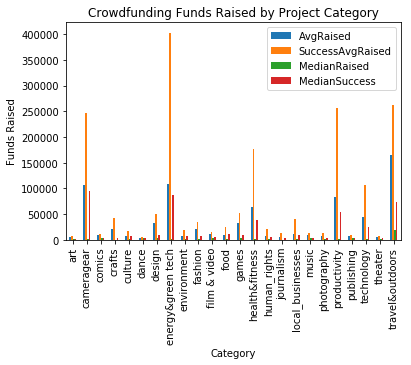

<Figure size 43200x21600 with 0 Axes>

In [20]:
# Compare the money raised by succesfull projects against all projects in a certain category
money = pd.DataFrame()
grp = merged.groupby(['fullcats'])
sucGrp = suc.groupby(['fullcats'])
money['AvgRaised'] = grp.usd_pledged.agg(np.mean)
money['SuccessAvgRaised'] = sucGrp.usd_pledged.agg(np.mean)
money['MedianRaised'] = grp.usd_pledged.agg(np.median)
money['MedianSuccess'] = sucGrp.usd_pledged.agg(np.median)
#money.reset_index(inplace = True)

ax = money.plot(kind = 'bar', title='Crowdfunding Funds Raised by Project Category')
ax.set_xlabel("Category")
ax.set_ylabel("Funds Raised")
plt.figure(figsize=(600,300))


# Comparing pledge goals

The same skew shows up in the fundraising goals for each project, there seems to be a few projects that have very high funding goals.

What's interesting here is that most projects have significantly lower funding goals than the top projects. It's difficult to see, but it also seems there's a relatively small difference in the median funding goals between successful projects and all projects

<Figure size 43200x21600 with 0 Axes>

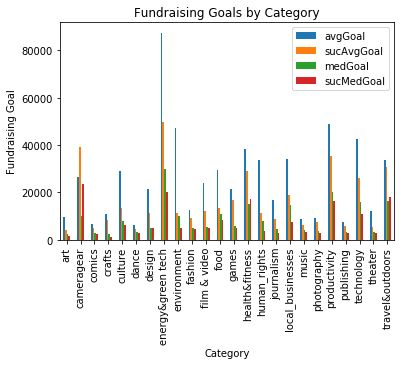

<Figure size 43200x21600 with 0 Axes>

In [21]:
# Delete old dataframes to reduce working memory
del money

# Compare the funding goals for successful projects in each category vs. the funding goals of all projects
goal = pd.DataFrame()
goal['avgGoal'] = grp.goal.agg(np.mean)
goal['sucAvgGoal'] = sucGrp.goal.agg(np.mean)
goal['medGoal'] = grp.goal.agg(np.median)
goal['sucMedGoal'] = sucGrp.goal.agg(np.median)

plt.close()
ax = goal.plot(kind = 'bar', title='Fundraising Goals by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Fundraising Goal")
plt.figure(figsize=(600,300))

# Rates of Success across Categories

Certain categories have much higher rates of success than others.

Comics, publishing, dance, music, and theater all have success rates of 70% or more

An interesting point is that these categories are tied to an individual creator, that have a dedicated fanbase they can draw from

Additionally, projects that require a good to be produced (ie technology products, health and fitness equipment, productivity tools) generally score lower

There's no binding rule for Kickstarter or indiegogo projects to produce the final product, all they require is that creators make a best faith effort. Since there's some inherent risks to these products being produced, it seems like consumers may be weighing that in their backing decisions

<Figure size 43200x21600 with 0 Axes>

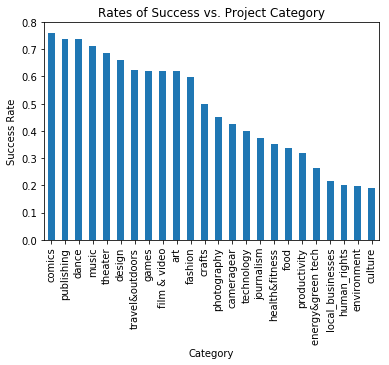

<Figure size 43200x21600 with 0 Axes>

In [22]:
del goal

plt.close()
catCounts = pd.DataFrame()
catCountAll = merged.groupby('fullcats').count()
catCountSuc = suc.groupby('fullcats').count()
catCounts['total_counts'] = catCountAll['source']
catCounts['success_counts'] = catCountSuc['source']
catCounts['successRate'] =  catCounts['success_counts']/catCounts['total_counts']
catCounts = catCounts.sort_values(by = ['successRate'], axis = 0, ascending = False)

ax = catCounts.successRate.plot(kind = 'bar', title='Rates of Success vs. Project Category')
ax.set_xlabel("Category")
ax.set_ylabel("Success Rate")
plt.figure(figsize=(600,300))

## Funding success across categories

The most popular categories generally have the lowest success rates, while things like comics, design photography, and games seem to perform better than average.

These categories would likely typically have fanbases that closely follow the creators. Due to this, they have a reliable audience to draw from when try to source funds for their campaigns

<Figure size 43200x21600 with 0 Axes>

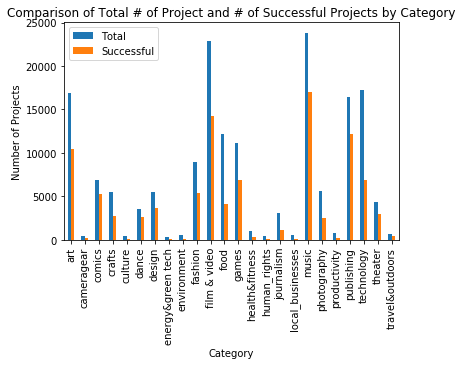

<Figure size 43200x21600 with 0 Axes>

In [23]:
# Look at the number of successfully funded projects in each category vs. the total number of projects
del catCounts

counts = pd.DataFrame()
counts['Total'] = grp.size()
counts['Successful'] = sucGrp.size()

plt.close()
ax = counts.plot(kind = 'bar', title='Comparison of Total # of Project and # of Successful Projects by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Number of Projects")
plt.figure(figsize=(600,300))

## Success rate of projects above a certain amount raised

Because of the large differences between the average funds raised and the median funds raised, it seems like there would be a large number of projects that raise hardly any money at all. 

Let's take a closer look project success rate versus the amount of money raised

Text(0.5, 1.0, 'Funding Goals and Success Rates')

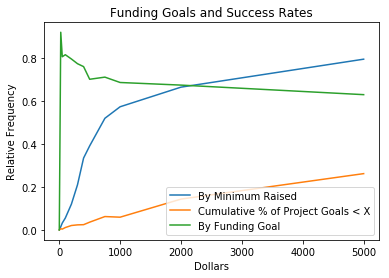

In [24]:
del counts

minRaised = [1, 25, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 5000]
lowGoals = [1, 25, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 5000]
succRate = []
goalRate = []
lowGoalSuccess = []
for raised in range(len(minRaised)):
    gotMoney = merged[(merged['usd_pledged'] >= minRaised[raised - 1]) & (merged['usd_pledged'] <= minRaised[raised])]
    gotMoneySuccess = gotMoney[(gotMoney['state'] == 'successful') | (gotMoney['state'] == 'finished')]
    if len(gotMoney) == 0:
        tempRate = 0
    else:
        tempRate = len(gotMoneySuccess) / len(gotMoney)
    succRate.append(tempRate)

for goals in range(len(lowGoals)):
    goalFilter = merged[(merged['goal'] <= lowGoals[goals]) & (merged['goal'] >= lowGoals[goals - 1])]
    lowSuccess = goalFilter[(goalFilter['state'] == 'successful') | (goalFilter['state'] == 'finished')]
    if len(lowSuccess) == 0:
        tempLowSuccess = 0
    else:
        tempLowSuccess = len(lowSuccess) / len(goalFilter)
    tempGoals = len(goalFilter) / len(merged)
    goalRate.append(tempGoals)
    lowGoalSuccess.append(tempLowSuccess)
    
graph = pd.DataFrame({'Dollars' : minRaised,
                     'Minimum_Raised' : succRate,
                     '%_of_Projects' : goalRate,
                     'Success_by_Goal' : lowGoalSuccess})
x = graph['Dollars']
y1 = graph['Minimum_Raised']
y2 = graph['%_of_Projects']
y3 = graph['Success_by_Goal']

plt.close()
plt.plot(x, y1, x, y2, x, y3)
plt.legend(('By Minimum Raised', 'Cumulative % of Project Goals < X', 'By Funding Goal'),
           loc='lower right')
plt.xlabel('Dollars')
plt.ylabel('Relative Frequency')
plt.title('Funding Goals and Success Rates')


## Funding Goals, Minimum Amount Raised, and Success Rates

In the plot above:
'By Minimum Raised' Shows relative frequency of success in projects that raised at least the amounts on the x axis

'Cumulative % of Project Goals' shows the % of projects that have funding goals less than the amounts on the x axis

'By Funding Goal' shows relative frequency of successful projects that have goals lower than amounts on the x axis

While a small % of projects have funding goals less than $1,000, projects that raised up to that amount have an outsized chance of meeting their funding goal. 

This idea seems to stress the importance of finding ambitious "first movers" from the general public to pledge support to projects and share with their friends. This supports the idea that project categories which have fanbases that closely follow project creators have a much better chance at reaching their funding goals. 

Let's take a closer look at the number of backers

### Time between Project Creation and Project Launch

Kickstarter allows creators to create a landing page for their projects before the project is officially launched. This time is for creators to raise awareness about the funding campaign, field questions from potential donors and tweak the campaign before making it live

There's a clear relationship showing that a delay of between 20 and 30 days gives the most benefit 

Text(0.5, 1.0, 'Success Rates vs. Number of Days between Launch and Creation')

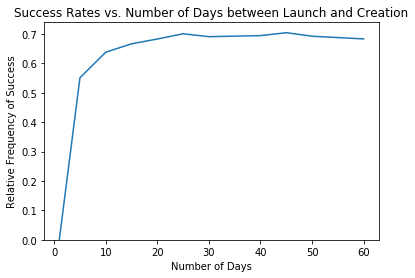

In [25]:
del gotMoney
del gotMoneySuccess
del goalFilter
del lowSuccess
del graph

# Plot the delta between launch and creation date vs. success rate
# Plot the campaign length against success rate
launchCreate = [1, 5, 10, 15, 20, 25, 30, 40, 45, 50, 60]
launchSuccess = []
for i in range(len(launchCreate)):
    longTemp = merged[(merged['creLauDelta'] <= launchCreate[i]) & (merged['creLauDelta'] >= launchCreate[i - 1])]
    longTempSuccess = longTemp[(longTemp['state'] == 'successful') | (longTemp['state'] == 'finished')]
    if len(longTemp) == 0:
        tempRate = 0
    else:
        tempRate = len(longTempSuccess) / len(longTemp)
    launchSuccess.append(tempRate)

graph = pd.DataFrame({'creLauDelta' : launchCreate,
                     'Success_by_Delta' : launchSuccess})
x = graph['creLauDelta']
y1 = graph['Success_by_Delta']

plt.close()
plt.plot(x, y1)
plt.ylim(bottom=0)
plt.xlabel('Number of Days')
plt.ylabel('Relative Frequency of Success')
plt.title('Success Rates vs. Number of Days between Launch and Creation')

### Project Launch Date and Success Rate 

Along with that, projects being successfully funded seems to have dropped off slightly in the last few years

Text(0.5, 1.0, 'Launch Date vs. Funds Raised Percent')

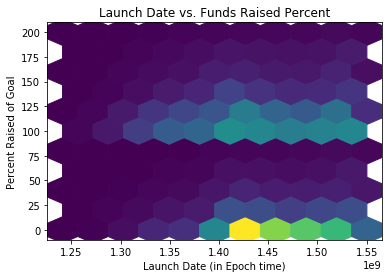

In [26]:
del longTemp
del longTempSuccess

noOutliers = merged[merged['funds_raised_percent'] < 200]
x = noOutliers['launched_at']
y = noOutliers['funds_raised_percent']

plt.close()
plt.hexbin(x, y, gridsize=10)
plt.xlabel('Launch Date (in Epoch time)')
plt.ylabel('Percent Raised of Goal')
plt.title('Launch Date vs. Funds Raised Percent')

### Alexa Site Rank and Success Rate

Look at the success rate of campaign funding and the Alexa site ranking

There seems to be a slight increase in projects reaching their funding goals when Kickstarter is more popular than other websites in general

/Users/chrismay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, 'Alexa Site Ranking vs. Funds Raised Percent')

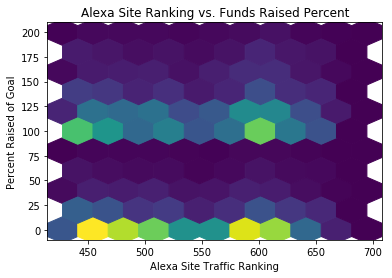

In [27]:
noOutliers = merged[(merged['funds_raised_percent'] < 200)]
noOutliers.dropna(axis = 0, inplace = True)

x = noOutliers['kickstarter.com']
y = noOutliers['funds_raised_percent']

plt.close()
plt.figure()

plt.hexbin(x, y, gridsize=10)
plt.xlabel('Alexa Site Traffic Ranking')
plt.ylabel('Percent Raised of Goal')
plt.title('Alexa Site Ranking vs. Funds Raised Percent')

## The Importance of Creators in Project Funding Success

In the previous section, there seemed to be a relationship between categories that have dedicated fanbases and an increaesd success rate in reaching funding goals.

To further explore that relationship, make some comparisons grouping projects by the number of other projects a certain creator has launched

Count the number of projects that a certain creator ID has launched, and then add that as a column to the dataframe

In [28]:
creaGroup = pd.DataFrame()
creators = pd.DataFrame()

plt.close()
# Group all projects by creator id and then merge that into the dataframe
creaGroup = merged.groupby('creator').count()
grouped = creaGroup.sort_values(by = ['backers_count'])
grouped = grouped.reset_index()
creators['creator'] = grouped['creator']
creators['no_projects'] = grouped['backers_count']
creators.head()
merged = merged.merge(creators, how = 'left', on = 'creator')

### Relationship between number of projects launched and success rate

There's a small subset of creators that have launched multiple projects. From the chart below, there's an increased rate of success as the number of projects launched by a particular creator increases. Note that this plot is shown by total number of projects, and does not consider the order in which projects were launched by a particular creator

Text(0.5, 1.0, 'Number of Creator Projects and Success Rate')

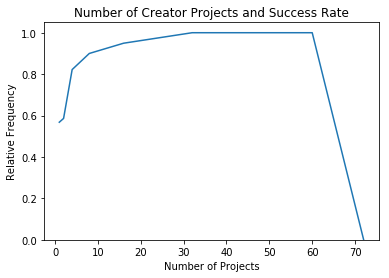

In [29]:
noProjects = [1, 2, 4, 8, 16, 32, 60, 72]
suc = merged[(merged['state'] == ('successful')) | (merged['state'] == ('finished'))]
multi = []
for i in noProjects:
    tempProj = merged[(merged['no_projects'] <= (i)) & (merged['no_projects'] >= (i - 1))]
    tempSucProj = suc[(suc['no_projects'] <= (i)) & (suc['no_projects'] >= (i - 1))]
    if len(tempProj) != 0:
        sucRate = len(tempSucProj) / len(tempProj)
    else:
        sucRate = 0
    multi.append(sucRate)

multiGraph = pd.DataFrame()
multiGraph['no_projects'] = noProjects
multiGraph['success_rate'] = multi
               
x = multiGraph['no_projects']
y1 = multiGraph['success_rate']

plt.close()
plt.plot(x, y1)
plt.ylim(bottom=0)
plt.xlabel('Number of Projects')
plt.ylabel('Relative Frequency')
plt.title('Number of Creator Projects and Success Rate')


# This is where I left off with the memory reduction

### Number of projects launched and percent of goal raised

There also seems to be an increase in average % of goal raised as the number of projects increases. Above 15, the sample size for each category drastically decreases (ie the number of creators that launched more than 15 projects is very small. 

<Figure size 43200x21600 with 0 Axes>

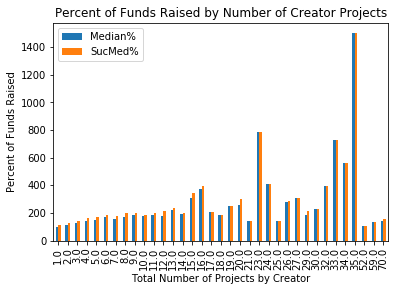

<Figure size 43200x21600 with 0 Axes>

In [30]:
# Compare the money raised by succesfull projects against all projects in a certain category
projects= pd.DataFrame()
proGroup = merged.groupby(['no_projects'])
sucProGrp = suc.groupby(['no_projects'])
#projects['Avg%'] = proGroup.funds_raised_percent.agg(np.mean)
#projects['SucAvg%'] = sucProGrp.funds_raised_percent.agg(np.mean)
projects['Median%'] = proGroup.funds_raised_percent.agg(np.median)
projects['SucMed%'] = sucProGrp.funds_raised_percent.agg(np.median)
#money.reset_index(inplace = True)

plt.close()
ax = projects.plot(kind = 'bar', title='Percent of Funds Raised by Number of Creator Projects')
ax.set_xlabel("Total Number of Projects by Creator")
ax.set_ylabel("Percent of Funds Raised")
plt.figure(figsize=(600,300))

### Number of Projects launched by each creator by category

Visual and performing arts projects are most frequently have creators with a high number of projects. The median number of projects for each creator in each category is 1, so creators with multiple project history is a minority segment of the overall sample population

<Figure size 43200x21600 with 0 Axes>

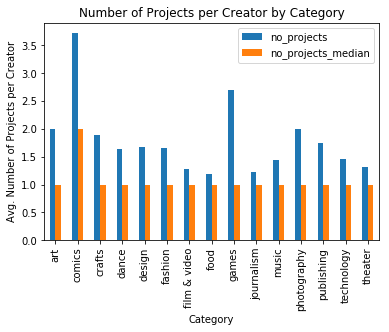

<Figure size 43200x21600 with 0 Axes>

In [31]:
create = pd.DataFrame()
createGrp = merged.groupby(['fullcats'])
create['no_projects'] = createGrp.no_projects.agg(np.mean)
create['no_projects_median'] = createGrp.no_projects.agg(np.median)
create.dropna(axis = 0, inplace = True)

plt.close()
ax = create.plot(kind = 'bar', title='Number of Projects per Creator by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Avg. Number of Projects per Creator")
plt.figure(figsize=(600,300))

### The total number of projects vs. creators with multiple projects

The next plot shows the number of projects in each category and compares that with the number of projects with creators who have launhed multiple proejcts.

It's easy to see in this plot that most creators in this dataset have only launched one project

<Figure size 43200x21600 with 0 Axes>

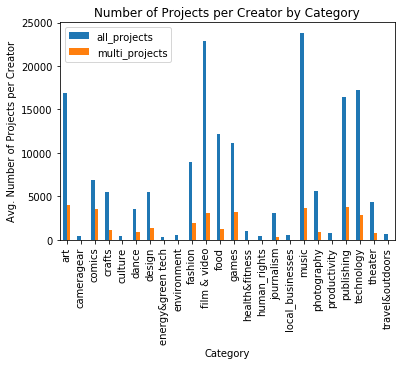

<Figure size 43200x21600 with 0 Axes>

In [32]:
createNumber = pd.DataFrame()
multi = merged[merged['no_projects'] > 1]
createGrp = merged.groupby(['fullcats'])
multiGrp = multi.groupby(['fullcats'])
createNumber['all_projects'] = createGrp.no_projects.size()
createNumber['multi_projects'] = multiGrp.no_projects.size()
createNumber.dropna(axis = 0, inplace = True)

plt.close()
ax = createNumber.plot(kind = 'bar', title='Number of Projects per Creator by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Avg. Number of Projects per Creator")
plt.figure(figsize=(600,300))

Text(0.5, 1.0, '% of Goal Raised and Number of Projects by Creator')

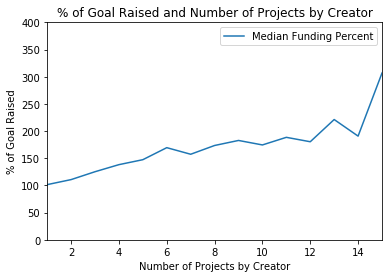

In [33]:
createNoProjects = pd.DataFrame()
noProjects = merged.groupby(['no_projects'])
createNoProjects['funding_percent_avg'] = noProjects.funds_raised_percent.agg(np.mean)
createNoProjects['funding_percent_med'] = noProjects.funds_raised_percent.agg(np.median)
createNoProjects['staLauDelta_avg'] = noProjects.staLauDelta.agg(np.mean)
createNoProjects['staLauDelta_med'] = noProjects.staLauDelta.agg(np.median)
createNoProjects.reset_index(inplace = True)

x = createNoProjects['no_projects']
y1 = createNoProjects['funding_percent_avg'] = noProjects.funds_raised_percent.agg(np.mean)
y2 = createNoProjects['funding_percent_med'] = noProjects.funds_raised_percent.agg(np.median)

plt.close()
plt.plot(x,y2)
plt.legend(('Median Funding Percent', 'Median Funding Percent'), loc='upper right')
plt.xlabel('Number of Projects by Creator')
plt.ylabel('% of Goal Raised')
plt.ylim(bottom=0)
plt.ylim(top = 400)
plt.xlim(right=15)
plt.xlim(left=1)
plt.title('% of Goal Raised and Number of Projects by Creator')

Text(0.5, 1.0, 'Dollars Raised and Number of Projects by Creator')

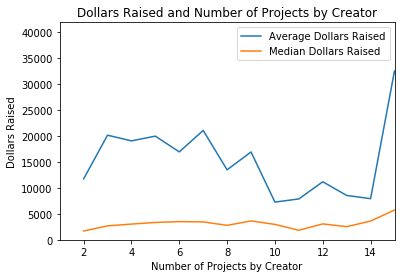

In [34]:
createNoProjects['usd_pledged_avg'] = noProjects.usd_pledged.agg(np.mean)
createNoProjects['usd_pledged_med'] = noProjects.usd_pledged.agg(np.median)

x = createNoProjects['no_projects']
y1 = createNoProjects['usd_pledged_avg']
y2 = createNoProjects['usd_pledged_med'] 

plt.close()
plt.plot(x,y1,x,y2)
plt.legend(('Average Dollars Raised', 'Median Dollars Raised'), loc='upper right')
plt.xlabel('Number of Projects by Creator')
plt.ylabel('Dollars Raised')
plt.ylim(bottom=0)
plt.xlim(right=15)
plt.xlim(left=1)
plt.title('Dollars Raised and Number of Projects by Creator')

Text(0.5, 1.0, 'Days to Goal and Number of Projects by Creator')

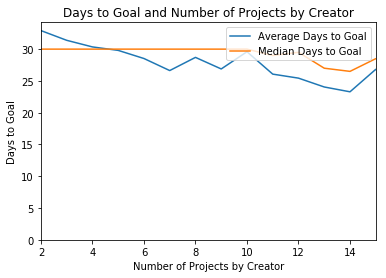

In [35]:
createNoProjects['staLauDelta_avg'] = noProjects.staLauDelta.agg(np.mean)
createNoProjects['staLauDelta_med'] = noProjects.staLauDelta.agg(np.median)

x = createNoProjects['no_projects']
y1 = createNoProjects['staLauDelta_avg']
y2 = createNoProjects['staLauDelta_med']

plt.close()
plt.plot(x,y1,x,y2)
plt.legend(('Average Days to Goal', 'Median Days to Goal'), loc='upper right')
plt.xlabel('Number of Projects by Creator')
plt.ylabel('Days to Goal')
plt.ylim(bottom=0)
plt.xlim(left=2)
plt.xlim(right=15)
#plt.ylim(ymax = 2000)
plt.title('Days to Goal and Number of Projects by Creator')

### Limiting the Results shown for Number of Projects by Creator

Above 14 projects per creator, the number of unique sample points drops off sharply to just a few creators. Rather than view results for sample sizes of 1 or 2, the above graphics were limited to creators that made 15 projects or fewer to show a better representation of the population

In [36]:
merged['no_projects'].value_counts()

1.0     120551
2.0      17190
3.0       5724
4.0       2744
5.0       1730
6.0       1200
7.0        700
8.0        448
11.0       374
10.0       370
9.0        360
12.0       264
13.0       182
17.0       153
14.0       140
16.0       112
18.0       108
15.0       105
26.0       104
19.0        95
20.0        80
25.0        75
70.0        70
32.0        64
59.0        59
52.0        52
23.0        46
35.0        35
34.0        34
33.0        33
30.0        30
29.0        29
27.0        27
24.0        24
21.0        21
Name: no_projects, dtype: int64

Text(0.5, 1.0, '% of Goal Raised and Days to Reach Goal')

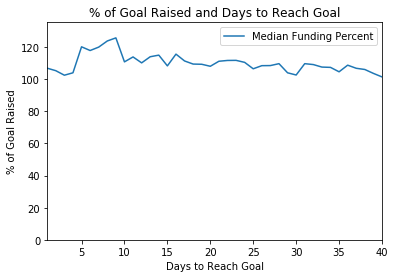

In [37]:
fundRate = pd.DataFrame()
rateProjects = merged.groupby(['staLauDelta'])
fundRate['funding_percent_avg'] = rateProjects.funds_raised_percent.agg(np.mean)
fundRate['funding_percent_med'] = rateProjects.funds_raised_percent.agg(np.median)

fundRate.reset_index(inplace = True)

x = fundRate['staLauDelta']
y2 = fundRate['funding_percent_med']

plt.close()
plt.plot(x,y2)
plt.legend(('Median Funding Percent', 'Median Funding Percent'), loc='upper right')
plt.xlabel('Days to Reach Goal')
plt.ylabel('% of Goal Raised')
plt.ylim(bottom=0)

plt.xlim(right=40)
plt.xlim(left=1)
plt.title('% of Goal Raised and Days to Reach Goal')

Text(0.5, 1.0, 'USD Pledged and Days to Reach Goal')

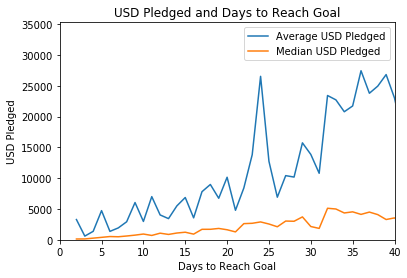

In [38]:
fundRate['usd_pledged_avg'] = rateProjects.usd_pledged.agg(np.mean)
fundRate['usd_pledged_med'] = rateProjects.usd_pledged.agg(np.median)

x = fundRate['staLauDelta']
y1 = fundRate['usd_pledged_avg']
y2 = fundRate['usd_pledged_med']

plt.close()
plt.plot(x,y1,x,y2)
plt.legend(('Average USD Pledged', 'Median USD Pledged'), loc='upper right')
plt.xlabel('Days to Reach Goal')
plt.ylabel('USD Pledged')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlim(right=40)
plt.title('USD Pledged and Days to Reach Goal')

### What's Happening here?

There's an odd abundance of projects that reach their funding goal either very close to, or on the deadline date.

Kickstarter.com has a section of their homepage dedicated to projects whose deadlines are within a certain time limit

We don't have data for funds raised per day, but it seems plausible that the presence on the homepage plus the urgency of a project being close to its goal and end date motivates backers on the fence to contribute

It's also plausible that towards the end of a fundraising campaing, projects push more incentive messages to their target audience

![Kickstarter's "Home Stretch"](https://i.imgur.com/rCG7hj0.png)

### Effects of Staff Picks and Project Spotlights on Campaign Success

As mentioned above, Kickstarter highlights certain projects on their homepage

The dataset that I have includes "Staff Pick" tags, for projects that Kickstarter staff favors

The spotlight tag is a little more ambiguous, but based on the success rate of spotlight projects, it seems like all successfully funded projects are spotlighted at some point

The success rate for staff pick projects is almost 90%, and the rate for spotlighted projects is 100%

In [39]:
staff = merged[(merged['staff_pick'] == True) & (merged['source'] == 'Kickstarter')]
staffSucc = staff[(staff['state'] == 'successful')]
spot = merged[(merged['spotlight'] == True) & (merged['source'] == 'Kickstarter')]
spotSucc = spot[(spot['state'] == 'successful')]
unstaff = merged[(merged['staff_pick'] == False) & (merged['source'] == 'Kickstarter')]
unstaffSucc = unstaff[unstaff['state'] == 'successful']
mergeKick = merged[merged['source'] == 'Kickstarter']

In [40]:
staffRate = len(staffSucc)/ len(staff)
spotRate = len(spotSucc)/len(spot)

print(staffRate, spotRate)

0.8954918032786885 1.0


<Figure size 43200x21600 with 0 Axes>

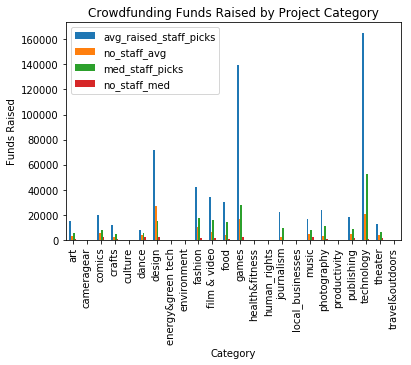

<Figure size 43200x21600 with 0 Axes>

In [41]:
staffMoney = pd.DataFrame()
staffGrp = staff.groupby(['fullcats'])
noStaff = unstaff.groupby(['fullcats'])
staffMoney['avg_raised_staff_picks'] = staffGrp.usd_pledged.agg(np.mean)
staffMoney['no_staff_avg'] = noStaff.usd_pledged.agg(np.mean)
staffMoney['med_staff_picks'] = staffGrp.usd_pledged.agg(np.median)
staffMoney['no_staff_med'] = noStaff.usd_pledged.agg(np.median)

plt.close()
ax = staffMoney.plot(kind = 'bar', title='Crowdfunding Funds Raised by Project Category')
ax.set_xlabel("Category")
ax.set_ylabel("Funds Raised")
plt.figure(figsize=(600,300))

In [42]:
unstaff = merged[merged['staff_pick'] == False]
unstaffSucc = unstaff[unstaff['state'] == 'successful']
print('the number of successful projects that were not staff picks is ', len(unstaffSucc))
print('the number of successful projects that are staff picks is ', len(staffSucc))
kickOnly = merged[merged['source'] == 'Kickstarter']
print('the total number of projects is ', len(kickOnly))

the number of successful projects that were not staff picks is  74943
the number of successful projects that are staff picks is  19228
the total number of projects is  153333


<Figure size 43200x21600 with 0 Axes>

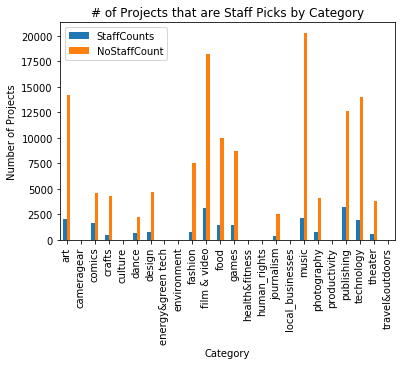

<Figure size 43200x21600 with 0 Axes>

In [43]:
staffMoney = pd.DataFrame()
staffMoney['StaffCounts'] = staffGrp.size()
staffMoney['NoStaffCount'] = noStaff.size()

plt.close()
ax = staffMoney.plot(kind = 'bar', title='# of Projects that are Staff Picks by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Number of Projects")
plt.figure(figsize=(600,300))

<Figure size 43200x21600 with 0 Axes>

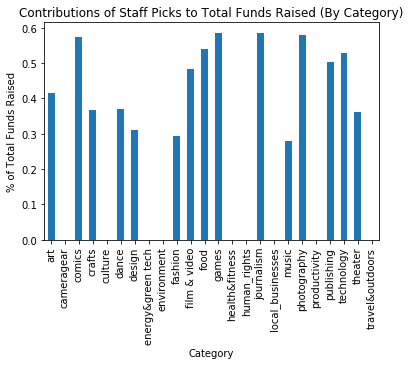

<Figure size 43200x21600 with 0 Axes>

In [44]:
allKick = mergeKick.groupby(['fullcats'])
noStaffCont = allKick.usd_pledged.agg(np.sum)
staffCont = staffGrp.usd_pledged.agg(np.sum)
contributions = pd.DataFrame()
contributions['staff_picks'] = staffCont / noStaffCont

plt.close()
ax = contributions.plot(kind = 'bar', title='Contributions of Staff Picks to Total Funds Raised (By Category)')
ax.get_legend().remove()
ax.set_xlabel("Category")
ax.set_ylabel("% of Total Funds Raised")
plt.figure(figsize=(600,300))

In [45]:
plt.close()
total = contributions.mean(axis = 0)
print('Kickstarter staff picks accounts for ', total, '% of all funds raised on average')

Kickstarter staff picks accounts for  staff_picks    0.451525
dtype: float64 % of all funds raised on average


### Correlation between Variables

Pandas has a method to do a pairwise correlation calculation for all pairs of columns that have numerical data

The only semi-strong correlated pairs are between the total number of backers and the total USD pledged. There's some other weaker correlations here, but in reality there's probably too many confounding factors to give a strong correlation.

Factors that are probably affecting the correlations
- Differences in required funding goals to bring projects to fruition across categories
- Varying scales of projects
- Prior creator history
- Individual backer tastes

Text(0.5, 1.0, 'Correlation Heatmap')

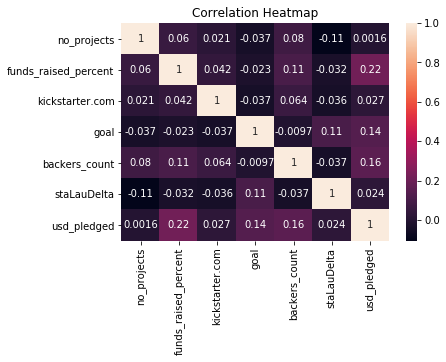

In [46]:
select = pd.DataFrame()
select['no_projects'] = merged['no_projects']
select['funds_raised_percent'] = merged['funds_raised_percent']
select['fullcats'] = merged['fullcats']
select['kickstarter.com'] = merged['kickstarter.com']
select['goal'] = merged['goal']
select['backers_count'] = merged['backers_count']
select['staLauDelta'] = merged['staLauDelta']
select['usd_pledged'] = merged['usd_pledged']
corr = select.corr()

plt.close()
sb.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')

# Appendix A: Data Descriptions

| Columns | Data Type | Description | 
|---|---|---|
|Backers Count| int64 | Total number of individual backers of a project
|Blurb|object| The short description of the project
|Category| list | A list of categories that the project has been tagged under
|Country| string| Two character country code of the campaign’s headquarters
|Created_at|int64| The creation date of the campaign in epoch time
|Creator| string |A list of the creator’s name and their creator ID on Kickstarter.com
|Currency| string| A two character string of the domestic currency of the project
|Deadline| int64|The end date/time of the campaign in epoch time
|Goal| int64|The funding goal of the project in native currency
|Id| int64|The unique project ID
|Launched_at| int64|Launch date of the campaign in epoch time
|Location| string|The main location of the project
|Name| object|The name of the project
|Pledged| int64|Total amount pledged (in the project’s home currency)
|Slug| string|An abbreviated description of the project
|Spotlight|string|True/False categorical variable of whether the project was featured by Kickstarter
|Staff_pick|string|True/False categorical variable of whether the project was a staff pick or not
|State|string|Successful/Failed/Canceled/Active  categorical variable of the projects current status
|State_changed_at| int64|Time/date that the project changed states, in epoch time
|Static_usd_rate| int64|Static conversion rate between home currency and USD
|Urls| string|Various URL’s associated with the project
|Usd_pledged| int64|Total amount pledged, converted to USD


# Appendix B: Previous Work and Citations

[Good Audience](https://blog.goodaudience.com/kickstarter-projects-prediction-of-state-steps-for-a-beginner-analysis-f4630a50b7fe)<br>
•	Runs logistic regression, XGBoost, Random forests, LightGBM and an Ensemble method to try and predict whether a project will be successfully funded or not. Based on the Kaggle dataset (limited to 49k entries). Mainly focused on feature selection

[Towards Data Science](https://towardsdatascience.com/predicting-the-success-of-kickstarter-campaigns-3f4a976419b9)<br>
•	Again predictions on successful funding, based on funding goals, category, rewards levels, and location data. Uses random forests, logistic regression, and kNearest Neighbors

[Bentley University](https://www.bentley.edu/prepared/what-secret-perfect-kickstarter-campaign)<br>
•	Finds length of description and title are important
•	Also the date of the launch important (winter is the best month)
•	Higher average donations, shorter campaign durations


Text(0.5, 1.0, 'Kickstarter.com Alexa Ranking over Time')

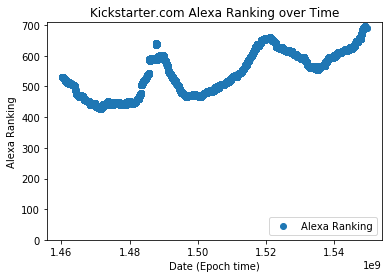

In [47]:
merged.head()
alexa = merged.copy()
alexa.dropna(axis = 0, inplace = True)

x = alexa['launched_at']
y = alexa['kickstarter.com']

plt.close()
plt.scatter(x, y)
plt.legend(('Alexa Ranking', 'Alexa ranking'), loc='lower right')
plt.xlabel('Date (Epoch time)')
plt.ylabel('Alexa Ranking')
plt.ylim(bottom=1)
plt.title('Kickstarter.com Alexa Ranking over Time')

In [48]:
plt.close()
merged.columns

Index(['backers_count', 'blurb', 'country', 'created_at', 'creator',
       'currency', 'deadline', 'fx_rate', 'goal', 'id', 'launched_at', 'name',
       'slug', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'urls',
       'usd_pledged', 'fullcats', 'city', 'creLauDelta', 'lauDeadDelta',
       'staLauDelta', 'source', 'funds_raised_percent', 'launch_date', 'Date',
       'kickstarter.com', 'no_projects'],
      dtype='object')

Text(0.5, 1.0, 'Distribution of % of Goal Raised')

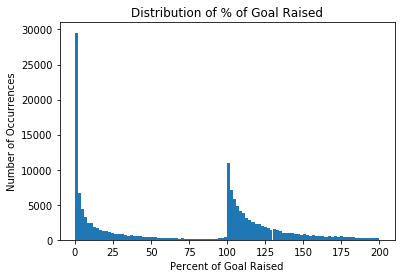

In [49]:
x = merged[(merged['funds_raised_percent'] < 200)]
y = x['funds_raised_percent']

plt.close()
plt.hist(y, bins = 100)
plt.xlabel('Percent of Goal Raised')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of % of Goal Raised')

/Users/chrismay/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chrismay/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Distribution of # of Days to Reach Goal')

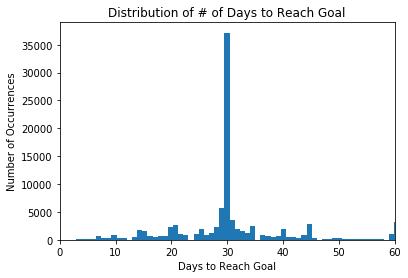

In [50]:
x = merged[merged['state'] == 'successful']
y = x['staLauDelta']

plt.close()
plt.hist(y, bins = 100)
plt.xlabel('Days to Reach Goal')
plt.ylabel('Number of Occurrences')
plt.xlim(left=0)
plt.xlim(right=60)
plt.title('Distribution of # of Days to Reach Goal')

In [51]:
from sklearn import preprocessing as pre
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

In [52]:
mergeKick.columns

Index(['backers_count', 'blurb', 'country', 'created_at', 'creator',
       'currency', 'deadline', 'fx_rate', 'goal', 'id', 'launched_at', 'name',
       'slug', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'urls',
       'usd_pledged', 'fullcats', 'city', 'creLauDelta', 'lauDeadDelta',
       'staLauDelta', 'source', 'funds_raised_percent', 'launch_date', 'Date',
       'kickstarter.com', 'no_projects'],
      dtype='object')

In [57]:
# Make a new dataframe with only the columns that we'll use for modeling
kickModel = pd.DataFrame()
kickModel['country'] = mergeKick['country']
kickModel['goal'] = mergeKick['goal']
kickModel['id'] = mergeKick['id']
kickModel['launched_at'] = mergeKick['launched_at']
kickModel['staff_pick'] = mergeKick['staff_pick']
kickModel['alexa_rank'] = mergeKick['kickstarter.com']
kickModel['creator_projects'] = mergeKick['no_projects']
kickModel['state'] = mergeKick['state']
kickModel['creLauDelta'] = mergeKick['creLauDelta']
kickModel['category'] = mergeKick['fullcats']

kickModel['staff_pick'] = kickModel.apply(lambda x: int(x['staff_pick'] == True), axis = 1)
kickModel['state'] = kickModel.apply(lambda x: int(x['state'] == 'successful'), axis = 1)
kickModel.head()

,country,goal,id,launched_at,staff_pick,alexa_rank,creator_projects,state,creLauDelta,category
0,US,5000,1203770415,1491540705,0,548.0,1.0,0,19.0,film & video
1,MX,3382,878861613,1509893074,0,528.0,1.0,1,16.0,film & video
2,NZ,6850,917345297,1427147079,0,NaN,1.0,1,7.0,theater
3,US,40000,1702164653,1487077744,1,589.0,1.0,1,49.0,comics
4,US,2000,1042930184,1507662001,0,503.0,1.0,1,16.0,games


In [58]:
dummies1 = pd.get_dummies(kickModel['category'], columns = 'category')
dummies2 = pd.get_dummies(kickModel['country'], columns = 'country')
kickModel = pd.concat([kickModel, dummies1], axis = 1)
kickModel = pd.concat([kickModel, dummies2], axis = 1)
kickModel.drop(labels = ['category', 'country'], axis = 1, inplace = True)
kickModel.head()

,goal,id,launched_at,staff_pick,alexa_rank,creator_projects,state,creLauDelta,art,cameragear,...,VE,VI,VN,VU,WS,XK,YE,ZA,ZM,ZW
0,5000,1203770415,1491540705,0,548.0,1.0,0,19.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3382,878861613,1509893074,0,528.0,1.0,1,16.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6850,917345297,1427147079,0,NaN,1.0,1,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40000,1702164653,1487077744,1,589.0,1.0,1,49.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2000,1042930184,1507662001,0,503.0,1.0,1,16.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
kickModel = kickModel.fillna(value = 1000, axis = 0)

In [83]:
X = kickModel.loc[:, kickModel.columns != 'state']
y = kickModel.loc[:, kickModel.columns == 'state']

#Use a MinMax scaler to standardize features
scaler = MinMaxScaler(feature_range = (0,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logreg.fit(X_train, y_train)

/Users/chrismay/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, uint32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/chrismay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chrismay/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [84]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.71


In [88]:
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

TypeError: 'numpy.ndarray' object is not callable

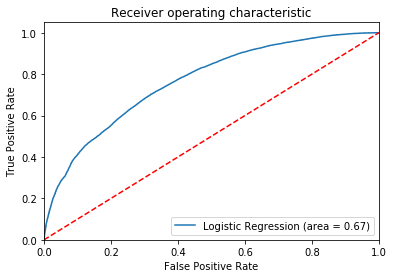

In [87]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### See if model performance can be improved using grid search